# NLP text analysis
#### This notebook builds on previously parsed messages, polls and webpages to perform topic analysis

In [5]:
# Tables, files and numbers
import pandas as pd, numpy as np, os, tqdm
from collections import Counter
import wget, zipfile, pickle

In [6]:
# Texts and words
import re
import enchant
import gensim
import nltk
from nltk.corpus import stopwords
import string
from ufal.udpipe import Model, Pipeline
from typing import List

In [7]:
# Models
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Images and plots
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Initial data load
msg = pd.read_pickle('./jksimvol__2020_05_19 23_42/tables/msg_df.pkl').drop_duplicates('msg_id')
wp = pd.read_pickle('./jksimvol__2020_05_19 23_42/tables/webpages.pkl')
polls = pd.read_pickle('./jksimvol__2020_05_19 23_42/tables/polls.pkl')

## Prepare data
- drop messages of people entering/leaving chat
- Append webpage title to text
- Append poll question to text
- Append replied posts (and replied of replied posts) to text
- Lower-case and remove punctuation

In [10]:
train = (msg[(msg.msg_type=='normal')&
             (msg.is_bot==False)]
         .drop(['msg_type','fwd_from','views','is_bot','user_name','media_type'], axis=1)
         .merge(wp[['msg_id','title']].copy().rename(columns={'title':'web_title'}), how='left')
         .merge(polls[['msg_id','question']].copy(), how='left')
         .merge(msg[['msg_id','message','reply_to_msg_id']].copy()
                .merge(msg[['msg_id','message']].copy().rename(columns={'msg_id':'reply_to_msg_id',
                                                                         'message':'message_prev_2'}), how='left')
                .drop('reply_to_msg_id', axis=1)
                .rename(columns={'msg_id':'reply_to_msg_id','message':'message_prev_1'}), how='left')
         .drop(['date','reply_to_msg_id'], axis=1))

train['message_full'] = (train.message.astype(str) +' ' + 
                         np.where(train.web_title.isnull(),'',train.web_title.astype(str) + ' ')  +
                         np.where(train.question.isnull(),'',train.question.astype(str) + ' ')  +
                         np.where(train.message_prev_1.isnull(),'',train.message_prev_1.astype(str) + ' ') +
                         np.where(train.message_prev_2.isnull(),'',train.message_prev_2.astype(str) + ' ')).str.lower()

train['message_full'] = train['message_full'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

train.drop(['message','web_title','question','message_prev_1','message_prev_2'], axis=1, inplace=True)

train.sample(5).style.set_caption(train.shape)

,msg_id,message_full
801,78708,у меня приставка управляется через блютуз к одной приставке можно несколько тв подцепить и если они в смежных комнатах то сигнал от пульта достает да и у кого 5 телеков то в квартире а если в квартире 5 телевизоров это пять поставок явно кабель не дешевле
1132,78361,да окончательно решил сдавать а тут уже просто арифметика чем меньше расходов на коммуналку тем выгоднее роман почему что случилось вам платёжка за последний месяц пришла я вообще не ёрничаю если что я своих платёжек ещё не видела ни одной и с маторином не подписывала договор так что даже когда увижу в текущих условиях скорее всего просто займу выжидательную позицию и не буду пока платить но ситуация с вывозом мусора вчера меня просто возмутила и вывела из равновесия у меня у мужа была ситуация один в один в химках в начале нулевых чувствуешь себя блин как в каком то прошлом да не пугает уже совершенно жилищник даже наоборот начинает импонировать
1214,78272,never again у нас даже президент был с урала и как бы люди есть там серьёзные суровые так что да вполне может быть
773,78736,я бы сказала что дворы меньшее из зол у нас подъезды открыты кроме подземной парковки и охраны на первом ничем даже хуже у нас даже дворы открыты а чем сейчас отличаются от эконома
2423,76995,сейчас по документам решение осс маторина так и есть всё что сверх норматива должен заплатить маторин а они на собственников пытаются это переложить судя по квитанциям сверхнорматив оплачивает ук они же управляют домом поэтому они и должны сделать так чтобы потребление было в пределах нормативов одн поднять до космических масштабов полностью с вами согласна а вопрос кто платит сверх норматив это вопрос общего собрания участников как решит собрание так и будет тут разные варианты возможны когда собственники берут эти расходы на себя если видят что их не обманывает ук или платит нерадивые управляйки которые приняли сырой дом от застройщика или сами создали потери ресурсов


## Correct misspellings
**Intuition:**  
- split words into correct and incorrect
- for incorrect ones get list of suggested replacements
- chose the most frequent replacement among correct words

In [11]:
# MANUAL CORRECTIONS!!!
# Not definately required, but counting for text specific may help

# Here we replace word containing chat-special terms into normal term form
contains_list = {
    'smart':'смарт',
    'смарт':'смарт',
    'matorin':'маторин',
    'маторин':'маторин',
    'жилищник':'жилищник',
    'simvol':'символ',
    'символ':'символ',
    'nevelsk':'невельского',
    'невельск':'невельского'
}

# And change abbreviated words into full words
abb_change_list = {
    'кгм':'крупногабаритный мусор',
    'осс':"общее собрание собственников",
    "жк":"жилой комплекс",
    "дс":"донстрой",
    'ук':'управляющая компания',
    'одн':'общедомовые нужды',
    'тсж':'товарищество собственников жилья',
    'ттк':'третье транспортное кольцо'
}

for idx in train.index:
    l = train.loc[idx,'message_full'].split()
    for i in range(len(l)):
        if l[i] in abb_change_list:
            l[i] = abb_change_list[l[i]]
            continue
        for k in list(contains_list.keys()):
            if k in l[i]:
                l[i] = contains_list[k]
    train.loc[idx,'message_full'] = ' '.join(l)

In [12]:
# Collect all-words-corpus
all_words = []
for i in train.index:
    for w in train.loc[i,'message_full'].split():
        all_words.append(w)

print('%i words collected'%len(all_words))
word_count = Counter(all_words)
word_count_df = pd.DataFrame({'word':list(word_count.keys()),
                              'quant':list(word_count.values())}).sort_values('quant', ascending=False)
print('%i distinct words collected'%len(word_count_df))

92496 words collected
9713 distinct words collected


In [13]:
# Split words into correct ones and incorrect
c = enchant.Dict("ru_RU")
word_count_df['correct'] = word_count_df.word.apply(lambda x: c.check(x))
word_count_df['suggest'] = np.nan

correct_words = word_count_df[word_count_df.correct].copy()
incorrect_words = word_count_df[word_count_df.correct==False].copy()

# For incorrect ones collect siggestion lists
for idx in tqdm.tqdm_notebook(incorrect_words.index, desc="suggest replacements"):
    incorrect_words.loc[idx,'suggest'] = ' // '.join(c.suggest(incorrect_words.loc[idx,'word']))

In [14]:
# Choose the most frequent word from suggested
incorrect_words['corrected'] = np.nan
for idx in incorrect_words.index:
    w = str(incorrect_words.loc[idx,'word'])
    if len(w)<2:
        continue
    if incorrect_words.loc[idx,'quant']>5:
        incorrect_words.loc[idx,'corrected'] = incorrect_words.loc[idx,'word']
        continue
    if len(incorrect_words.loc[idx,'suggest'])<2:
        continue
    
     
    suggest_list = incorrect_words.loc[idx,'suggest'].split(' // ')
    avg_quants = []
    for s in suggest_list:
        sug_words = [i.strip() for i in s.split()]
        sw_quants = []
        for sw in sug_words:
            if len(sw)>2 and sw in correct_words.word:
                sw_quants.append(int(correct_words.loc[correct_words.word==sw,'quant']))
        if len(sw_quants) > 0:
            avg_quants.append(np.average(sw_quants))
        else:
            avg_quants.append(0)
    suggest_df = pd.DataFrame({'suggest':suggest_list,'avg_quant':avg_quants}).sort_values('avg_quant', ascending=False)
    
    incorrect_words.loc[idx,'corrected'] = suggest_df.head(1).suggest.values[0]

In [15]:
# Create word-correction dictionary
word_correction_dict = {}
for idx in incorrect_words[(incorrect_words.word!=incorrect_words.corrected.str.lower())&
                           (~incorrect_words.corrected.isnull())].index:
    if len(incorrect_words.loc[idx,'corrected'])>2:
        word_correction_dict[incorrect_words.loc[idx,'word']] = incorrect_words.loc[idx,'corrected'].lower()

In [16]:
print('%i distinct words corrected'%len(word_correction_dict))

663 distinct words corrected


In [17]:
# Apply correction to incorrect words
for idx in train.index:
    l = train.loc[idx,'message_full'].split()
    for i in range(len(l)):
        if l[i] in word_correction_dict:
            l[i] = word_correction_dict[l[i]]
    train.loc[idx,'message_full'] = ' '.join(l)

## Word Tokenization  
Functions perform several stages of word tokenization through pipeline:
1. Strips words
2. Removes stopwords
3. Tokenize and lemmatize each
4. Through language model attach word type to each word (NOUN, VERB, PRON, etc.)

In [18]:
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken

def clean_token(token, misc):
    """
    :param token:  токен (строка)
    :param misc:  содержимое поля "MISC" в CONLLU (строка)
    :return: очищенный токен (строка)
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token

def clean_lemma(lemma, pos):
    """
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def list_replace(search, replacement, text):
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text


def unify_sym(text):  # принимает строку в юникоде
    text = list_replace \
        ('\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019', '\u0022', text)

    text = list_replace \
        ('\u2012\u2013\u2014\u2015\u203E\u0305\u00AF', '\u2003\u002D\u002D\u2003', text)

    text = list_replace('\u2010\u2011', '\u002D', text)

    text = list_replace \
            (
            '\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000',
            '\u2002', text)

    text = re.sub('\u2003\u2003', '\u2003', text)
    text = re.sub('\t\t', '\t', text)

    text = list_replace \
            (
            '\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062',
            '.', text)

    text = list_replace('\u2217', '\u002A', text)

    text = list_replace('…', '...', text)

    text = list_replace('\u2241\u224B\u2E2F\u0483', '\u223D', text)

    text = list_replace('\u00C4', 'A', text)  # латинская
    text = list_replace('\u00E4', 'a', text)
    text = list_replace('\u00CB', 'E', text)
    text = list_replace('\u00EB', 'e', text)
    text = list_replace('\u1E26', 'H', text)
    text = list_replace('\u1E27', 'h', text)
    text = list_replace('\u00CF', 'I', text)
    text = list_replace('\u00EF', 'i', text)
    text = list_replace('\u00D6', 'O', text)
    text = list_replace('\u00F6', 'o', text)
    text = list_replace('\u00DC', 'U', text)
    text = list_replace('\u00FC', 'u', text)
    text = list_replace('\u0178', 'Y', text)
    text = list_replace('\u00FF', 'y', text)
    text = list_replace('\u00DF', 's', text)
    text = list_replace('\u1E9E', 'S', text)

    currencies = list \
            (
            '\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192'
        )

    alphabet = list \
            (
            '\t\n\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ,.[]{}()=+-−*&^%$#@!~;:0123456789§/\|"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ')

    alphabet.append("'")

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = ''.join(cleaned_text)

    return cleaned_text

def process(pipeline, text='строчка текста или вербатим', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # process text, get results in conllu format:
    processed = pipeline.process(text)

    # skip lines with hashes:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # get morphological features from prepared text
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

def tag_ud(model, text=['Текст нужно передать функции в виде строки!'], stoplist=[None]):
    process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    result = []
    #print('Processing input...', file=sys.stderr)
    for line in tqdm.tqdm_notebook(text):
        output = process(process_pipeline, text=line)
        result.append([w for w in output if w.split('_')[0] not in stoplist])
    return result

In [19]:
# Here we just load a prepared list of stopwords
# UNHASH IF YOU HAVEN'T DOWNLOADED IT YET nltk.download('stopwords')

In [20]:
# Download preprocessing model
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
modelfile = wget.download(udpipe_url)

100% [....................................................] 40616122 / 40616122

In [21]:
model_pp = Model.load(modelfile)
stop_list = stopwords.words('russian')

In [22]:
text = ['Шла Саша по шоссе и сосала сушку', 'Ваша киска купила бы Вискас!', 'И когда же меня отпустит?!']
for t,m in zip(text, tag_ud(model_pp, text, stoplist=stop_list)):
    print('\nFROM: \t%s \nTO: \t%s\n'%(t,m))



FROM: 	Шла Саша по шоссе и сосала сушку 
TO: 	['идти_VERB', 'саша_PROPN ', 'шоссе_NOUN', 'сосать_VERB', 'сушка_NOUN']


FROM: 	Ваша киска купила бы Вискас! 
TO: 	['ваш_DET', 'киска_NOUN', 'покупать_VERB', 'вискас_PROPN ']


FROM: 	И когда же меня отпустит?! 
TO: 	['отпустить_VERB']



In [23]:
train = train[(~train.message_full.isnull())&(train.message_full.astype(str).str.len()>2)]

In [24]:
corpus = tag_ud(model_pp, text=train.message_full.tolist(), stoplist=stop_list)
print('We transofrmed verbatims from this:\t',train.message_full.values[0],'\nInto this form:\t\t\t\t',corpus[0])


We transofrmed verbatims from this:	 мигранты уже под землей некоторых корпусов есть не соврал менеджер стоп стоп стоп менеджеры перед покупкой обещали выделенную линию метро 
Into this form:				 ['мигрант_NOUN', 'земля_NOUN', 'некоторый_DET', 'корпус_NOUN', 'врать_VERB', 'менеджер_NOUN', 'стопа_NOUN', 'стопа_NOUN', 'стопа_NOUN', 'менеджер_NOUN', 'покупка_NOUN', 'обещать_VERB', 'выделить_VERB', 'линия_NOUN', 'метро_NOUN']


In [25]:
# Delete repeated words (if repeated after each other)
corpus_corrected = []
for l in corpus:
    if len(l)<2:
        corpus_corrected.append(l)
        continue
    l_new = [l[0]]
    for i in range(1,len(l)):
        if l[i] != l[i-1]:
            l_new.append(l[i])
    corpus_corrected.append(l_new)

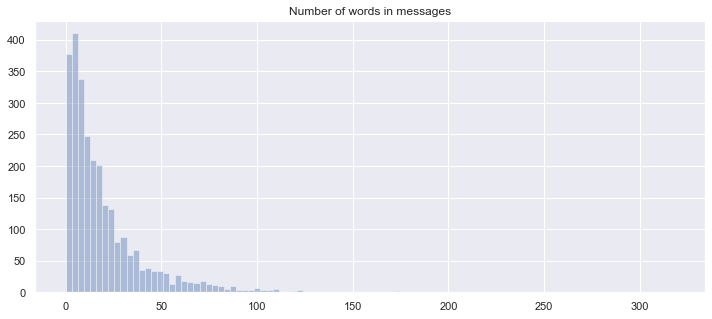

In [26]:
# Look on text sizes
lengths = [len(i) for i in corpus_corrected]
sns.set(rc={'figure.figsize':(12,5)})
sns.distplot(lengths, kde=False, bins=100)
plt.title('Number of words in messages')
plt.show();

## Filter words by IDF
**Intuition:** keep words which are not too message-specific and not to common

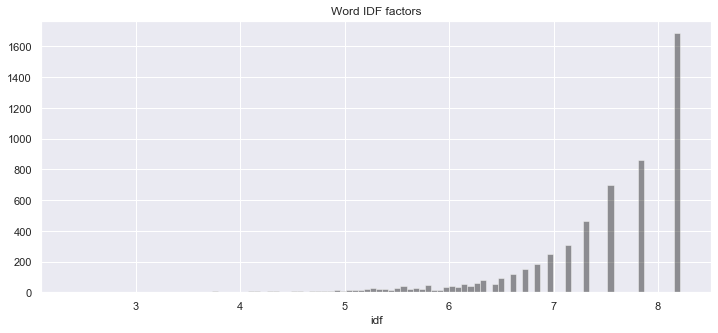

In [27]:
tf_idf = TfidfVectorizer().fit([' '.join(i) for i in corpus_corrected])
idf_df = pd.DataFrame({'word':tf_idf.get_feature_names(),'idf':tf_idf.idf_})

sns.set(rc={'figure.figsize':(12,5)})
sns.distplot(idf_df.idf, kde=False, bins=100, color='black')
plt.title('Word IDF factors')
plt.show();

In [28]:
filter_words = idf_df.loc[(idf_df.idf<(np.percentile(idf_df.idf.values,1)))|(idf_df.idf==idf_df.idf.max()),'word'].tolist()
print('Filter out %i words out of %i'%(len(filter_words),len(idf_df)))

Filter out 1742 words out of 5725


Remove words from filter and with not allowed indices from corpus

In [29]:
# As we are not interested in pronouns, prepositions and such, we'll keep only meaningful words
allowed_indices = ['NOUN', 'ADJ', 'VERB', 'ADV']
corpus_filtered = []
for s in corpus_corrected:
    s_new = []
    for w in s:
        if w not in filter_words and w.split('_')[1] in allowed_indices:
            s_new.append(w)
    corpus_filtered.append(s_new)

In [30]:
train['m_length'] =  [len(i) for i in corpus_filtered]
print('%i out of %i messages now have zero length. We remove them'%(len(train[train.m_length==0]),len(train)))
train = train[train.m_length>0]
corpus_filtered = [i for i in corpus_filtered if len(i)>0]

26 out of 2721 messages now have zero length. We remove them


## Transform words into 300-d vectors  
We'll use rusvectors model for it

In [31]:
model_url = 'http://vectors.nlpl.eu/repository/20/182.zip'
#UNCOMMENT FOR 1st RUN    m = wget.download(model_url)
model_file = model_url.split('/')[-1]

with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

Demonstration

In [32]:
word = 'мигрант_NOUN'
print('Five closest words to word "%s" by meaning'%word)
for i in model.most_similar(positive=[word], topn=5):
    print('\t',i[0])

Five closest words to word "мигрант_NOUN" by meaning
	 иммигрант_NOUN
	 беженец_NOUN
	 репатриант_NOUN
	 иммиграция_NOUN
	 гастарбайтер_NOUN


Let's remove words from corpus if it is not in model

In [33]:
corpus_clean = []
deleted_words = []
for s in corpus_filtered:
    s_new = []
    for w in s:
        if w in model:
            s_new.append(w)
        else:
            deleted_words.append(w)
    corpus_clean.append(s_new)

In [34]:
deleted_words = Counter(deleted_words)
del_w_df = pd.DataFrame({'del_word':list(deleted_words.keys()),
                         'counter':list(deleted_words.values())}).sort_values('counter',ascending=False)
del_w_df.head()

,del_word,counter
47,маторин_NOUN,382
50,смарть_NOUN,349
48,жилищникать_NOUN,270
45,смарт_NOUN,139
46,общедомовый_ADJ,99


There are some very frequent words which are not in language model.   
Let's count them as special terms and create additional columns in train for each.  
Then delete messages with zero length in clean corpus.  

In [35]:
train = train.reset_index(drop=True)

top_terms = del_w_df.head().del_word.tolist()
for t in top_terms:
    train[t] = False

for i in train.index:
    for t in top_terms:
        if t in corpus_filtered[i]:
            train.loc[i,t] = True
            
train['m_length'] =  [len(i) for i in corpus_clean]
print('%i out of %i messages now have zero length. We remove them'%(len(train[train.m_length==0]),len(train)))
train = train[train.m_length>0]
corpus_clean = [i for i in corpus_clean if len(i)>0]
            
print('Out of %i messages:\n'%train.shape[0])
for t in top_terms:
    print('\t%s:\t%i'%(t,train[train[t]].shape[0]))

14 out of 2695 messages now have zero length. We remove them
Out of 2681 messages:

	маторин_NOUN:	281
	смарть_NOUN:	273
	жилищникать_NOUN:	174
	смарт_NOUN:	128
	общедомовый_ADJ:	80


1 more manual correction :( смарть_NOUN = смарт_NOUN, so we combine two columns

And rename columns. 

In [36]:
train['смарт_NOUN'] = train['смарть_NOUN']|train['смарт_NOUN']
train.drop('смарть_NOUN', axis=1, inplace=True)
for c in train.columns:
    if c in top_terms:
        train = train.rename(columns={c:c.split('_')[0]})

## Word-Vectors into Verbatim-Vectors
There are several ways to calculate vector representation for whole sentences having vector representations for the containing words: one can use vector sum or average, but this way a lot of information is being lost.  
Much better approach is to through weihted sum using SIF weights. Put it simple, we devaluate not unique words (that appear in many sentences) and give more weight to unique words, as they are more defining for the exact verbatim. [For more information please refer to this article](https://openreview.net/pdf?id=SyK00v5xx).

In [37]:
# A SIMPLE BUT TOUGH TO BEAT BASELINE FOR SENTENCE EMBEDDINGS
# Sanjeev Arora, Yingyu Liang, Tengyu Ma
# Princeton University
# convert a list of sentence with word2vec items into a set of sentence vectors
def sentence_to_vec(sentence_list, word_weights, model, embedding_size=300, a: float=1e-3):
    sentence_set = []
    for sentence in tqdm.tqdm_notebook(sentence_list):
        vs = np.zeros(embedding_size)  # add all word2vec values into one vector for the sentence
        weights = np.zeros(embedding_size)
        for word in sentence:
            try:
                a_value = a / (a + word_weights[word])  # smooth inverse frequency, SIF
                weights= np.add(weights, a_value)
                vs = np.add(vs, np.multiply(a_value, model[word]))  # vs += sif * word_vector
            except:
                continue

        vs = np.divide(vs, weights)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    # calculate PCA of this sentence set
    pca = PCA()
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u,vs)
        sentence_vecs.append(np.subtract(vs, sub))

    return sentence_vecs

In [38]:
counter_dict = dict(Counter([item for sublist in corpus_clean for item in sublist]))
corpus_size = len(corpus_clean)
word_weights = {k:v/corpus_size for (k,v) in counter_dict.items()}

train_data = sentence_to_vec(corpus_clean, word_weights, model)

In [39]:
print('So we got %i verbatims embeded into %i-size vectors'%(np.shape(train_data)[0],np.shape(train_data)[1]))

So we got 2681 verbatims embeded into 300-size vectors


Let's check some random verbatims for the closest ones... We'll do it with vector cosine similarity.

In [42]:
def cos_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1*norm2)

def find_similar_verbatims(verbatims, verb_vectors, n_similar):
    verb_n = np.random.choice(len(verbatims))
    
    v = verbatims[verb_n]
    print('Finding %i similar verbatims for phraze:\n\n%s'%(n_similar, v))
    v_vec = verb_vectors[verb_n]
    sims = [cos_similarity(v_vec, i) for i in verb_vectors]
    temp = pd.DataFrame({'verbatims':verbatims,'sims':sims}).sort_values('sims', ascending=False)
    return temp[temp.verbatims!=v]['verbatims'].head(n_similar).values

In [49]:
verbs = msg[msg.msg_id.isin(train.msg_id.tolist())].message.values
sims = find_similar_verbatims(verbs, train_data, 5)
for v in sims:
    print('\n',v)

Finding 5 similar verbatims for phraze:

Спорное утверждение, что никогда не станут платить. Сейчас мизерные сборы с собственников - это "заслуга" ук, а не нежелание платить жителей.

 А что тогда тут у нас по быстрому 'снимать' по вашей логике?)))

 Вот поэтому ни одна нормальная УК сюда никогда не придёт чтобы работать,только чтобы «снимать» по быстрому и сваливать.Будет череда временщиков.Никто не станет вкладываться в нормальное уборочное оборудование,нанимать граждан России на работу и вообще что то здесь планировать для долгосрочной работы-здесь не платят и платить никогда не станут🙂

 +

 почему не платят? Я зашла на ремонт, заплатила депозит , вывоз мусора, если б мне по уму выставляли счета, я бы их оплачивала

 В суд пойдёт ук, так как им надо с нас получить Деньги. Нам достаточно просто не платить. 
Я консультировался - рекомендация не платить ничего, запросить у ук разъяснения по начислениям. Если ук идёт в суд, то там ей придётся по полочкам раскладывать показания по каждо

**Looks quite good, seems like our language model managed to derive some structure from verbatim!**

## GMM Clustering
GMM words quite well in language modeling. Let's apply one and chose number of clusters by AIC & BIC minimals

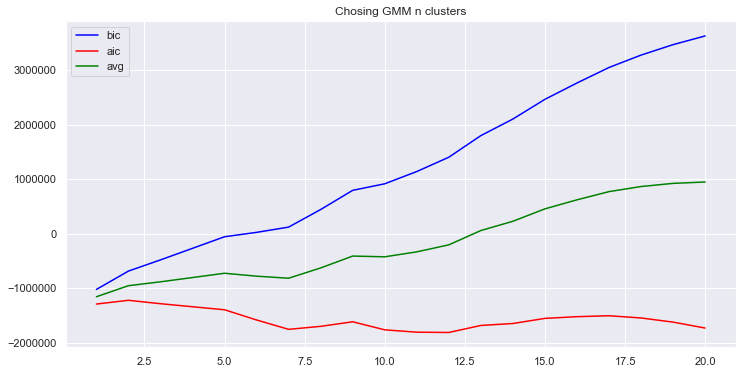

Number of clusters = 7


In [50]:
bic = []
aic = []
n_clusters = np.arange(1, 21)
gmm_train = np.array(train_data)
for n in tqdm.tqdm_notebook(n_clusters):
    mod = GMM(n, covariance_type='full', random_state=4242).fit(gmm_train)
    bic.append(mod.bic(gmm_train))
    aic.append(mod.aic(gmm_train))

aic_bic_avg = np.array(pd.Series(aic) + pd.Series(bic))/2
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(n_clusters, bic, color='blue')
plt.plot(n_clusters, aic, color='red')
plt.plot(n_clusters, aic_bic_avg, color='green')
plt.legend(['bic','aic','avg'])
plt.title('Chosing GMM n clusters')
plt.show();

n_clusters = int(input('Number of clusters = '))

In [51]:
#Train final GMM model with chosen n_clusters
gmm_final = GMM(n_clusters,covariance_type='full', random_state=4242).fit(gmm_train)

In [52]:
# Predict clusters for messages
train = train.reset_index(drop=True)
train['cluster'] = gmm_final.predict(train_data)
cl_sizes = train.cluster.value_counts().to_frame()
too_small_clusters = cl_sizes[cl_sizes.cluster<10].index.tolist()

# remove too small clusters (<10 observations)
for i in train[train.cluster.isin(too_small_clusters)].index:
    train_data.pop(i)
train = train[train.cluster.isin(too_small_clusters)==False]
for i in list(set(list(range(len(corpus_clean)))) - set(train.index)):
    corpus_clean.pop(i)

## Naming clusters
To name clusters we'll show 3 things about them:
1. Table of most defining words for each cluster (by maximum IDF sum)
2. TOP-5 messages most close to cluster center (by vector cosine distance)
3. Word-cloud for each cluster

After that user is prompted to enter a defining name for cluster

,1,2,3,4,5,6
0,комплекс,собрание,квитанция,тариф,этаж,происходить
1,жилой,собственник,оплачивать,электроэнергия,квартира,писать
2,собственник,суд,присылать,помещение,сосед,давать
3,человек,кворум,здравствовать,услуга,секция,знать
4,платить,голосовать,март,квартира,подъезд,смотреть
5,вообще,договор,ноябрь,нужда,вода,голосовать
6,общий,платить,почему,должен,балкон,человек
7,квартира,общий,отопление,жилой,каждый,вообще
8,делать,делать,почта,коммунальный,метр,окно
9,символ,нужный,адрес,объем,год,брать


		 ## CLUSTER 1 TOP-5 MESSAGES ##

В том и печаль. Действительно адекватный, даже показалось, что теперь все наладится - есть возможность обратной связи, есть прямой контакт. Но вот почему-то дальше не пошло. Наверное, конфронтация им ближе и понятней, не знаю 🤷‍♀️

Была смешная история про камеру, когда человека уверяли, что все убрали на этаже, отмыли точна-точна, пришли даже к нему, чтоб показать, что все убрано. Он молча рукой показал на камеру над дверью - и после неловкой паузы они согласились, что с уборкой пока не сложилось 😂

Я общался со Станиславом, очень адекватный, вежливый человек, рассуждает разумно. Но увы, дальше слов ничего не двигается. Предлагал встречу с жильцами сделать, просил встречу с Гендиректором смарт - в ответ да, все будет, но пока изоляция, сроков нет. Предлагал сделать встречу в зуме - не нашел отклика.
Также отправил Станиславу список из 20 самых насущных проблем в ЖК. Никакой обратной связи не получил. В телефонном разговоре Станислав подтвердил, что п

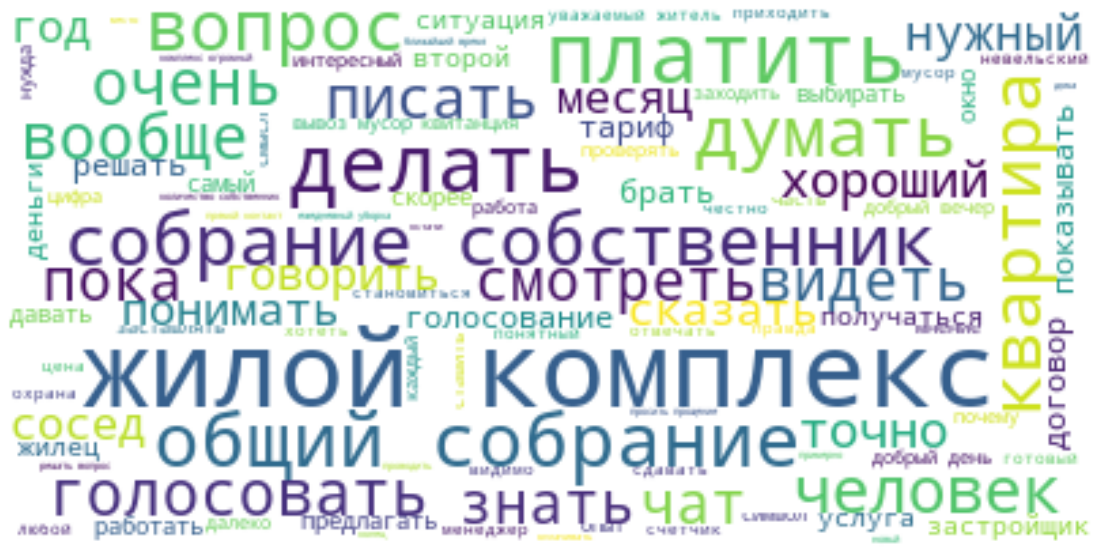

Please, name the cluster: сравнение УК
		 ## CLUSTER 2 TOP-5 MESSAGES ##

А идти(голосовать) на собрание(ОСС Смарта) которое организовывается и проводится с нарушением всех положений закона ( Указов, Постановлений, Кодексов) ЭТО активные действия собственника? На счёт «против», «Против Смарта» это подразумевает «За Маторин» (вопрос номер 2 Решение ОСС Смарта: «отказаться от исполнения договора управления МКД заключённого с ООО Маторин»). Вы не допускаете,  что Маторин в своё время не набрал кворума, голосов и теперь таким образом узаконивает своё положение..(наличие управляющей компании Маторин ещё никто в суде не  оспаривал, а к этому всё шло). Не нужно создавать себе (собственнику) лишних проблем, их и так воз и маленькая тележка..  Без УК(управляющей компании) дома не останутся, это уже давно отработанная ситуация, четко прописанная в ЖК, префектура назначит домам УК пока собственники не определятся с вопросом управления(содержания) МКД

🤝🤝🤝 Вот просто добавить нечего. 
Смарт меня п

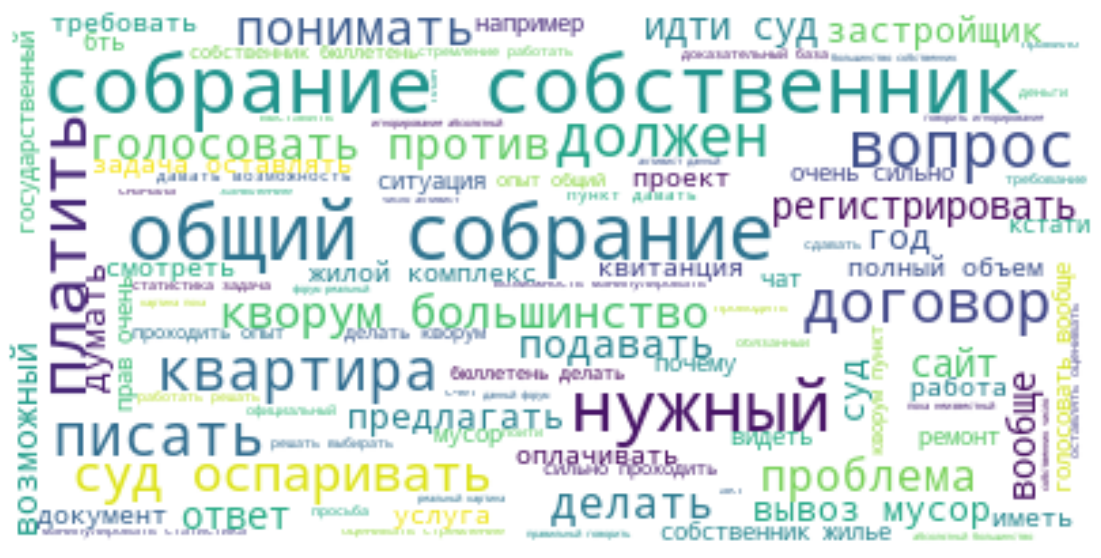

Please, name the cluster: ОСС и голосование
		 ## CLUSTER 3 TOP-5 MESSAGES ##

Да просто на почту письмо напишите с запросом

Мне звонили и на почту прислали 4 письма. Последнее вчера днем))

Сейчас скину

думаю Донстрой с МЖИ договорится и сделает кворум, на котором мы все выберем Смарт

Ехать не хочется


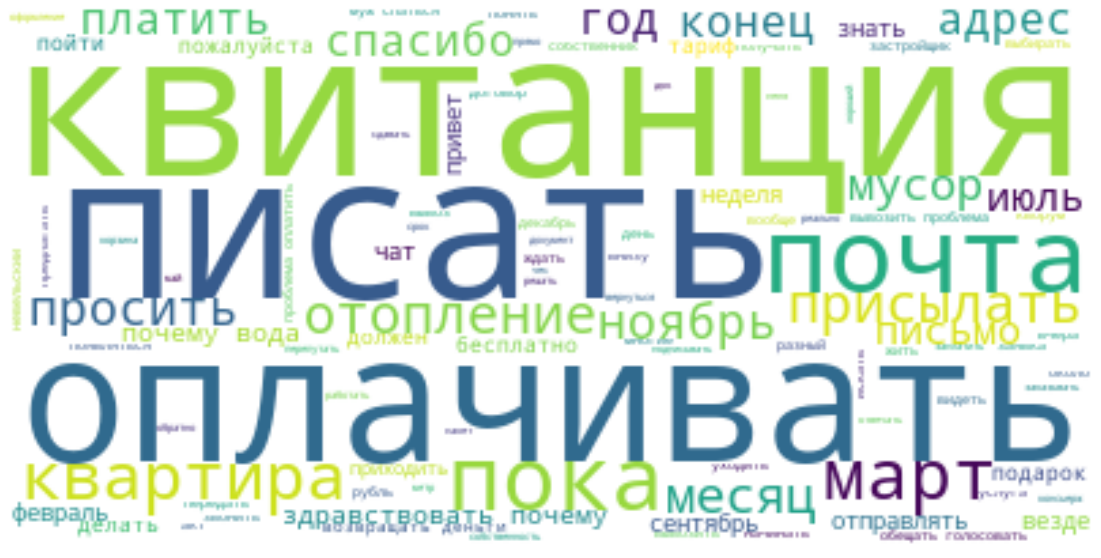

Please, name the cluster: оплата квитанций
		 ## CLUSTER 4 TOP-5 MESSAGES ##

Пока нет, ждём.

Цена раз в 10-12 выше рынка

У Донстроя никогда не включена

Разве мойка окон не включена в тариф УК?

Уважаемые жители!
Предлагаем вам воспользоваться услугой коллективной мойки окон методом промышленного альпинизма. 

Стоимость составляет 600 рублей/квадратный метр. Ориентировочные сроки мойки окон в вашем ЖК - с 22 июня по 12 июля. Заявку можно уже сейчас оформить по тел. 8-800-707-75-20. 

В июне с вами свяжется сотрудник, чтобы договориться о дате и времени для замеров. Окончательная стоимость работ рассчитывается после замеров, исходя из вашего объёма.  

——

📣 Расскажите про наш канал своим соседям в один клик - поделитесь с ними ссылкой https://t.me/simvol_smartvostok


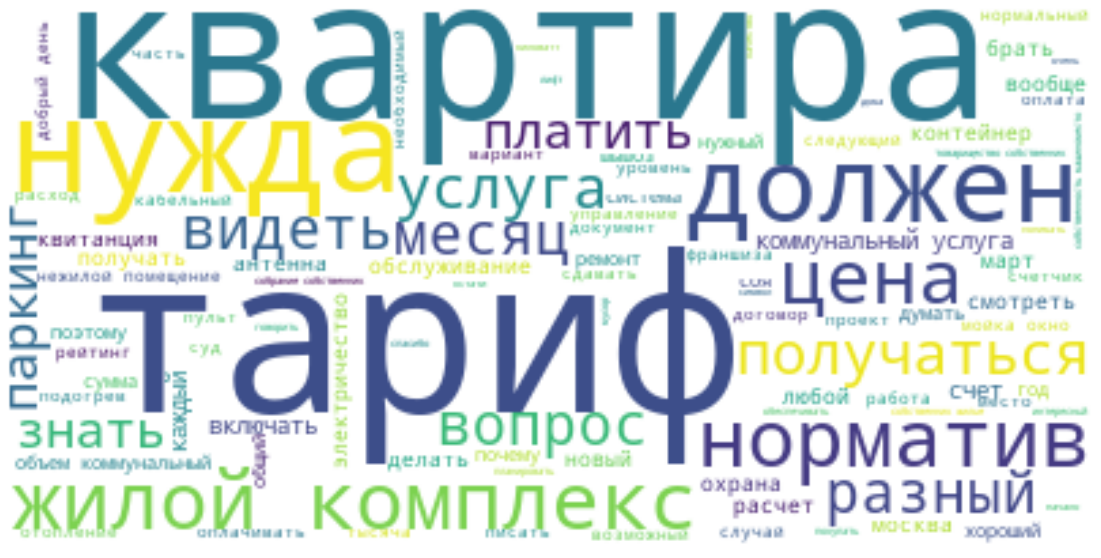

Please, name the cluster: коммунальные услуги
		 ## CLUSTER 5 TOP-5 MESSAGES ##

Вам повезло, у меня тоже Жилищник и для меня правда,  дрючу их только я, поэтому проводку поменяли только на моем этаже, после того, как щиток загорелся, и много чего такого, до ковида подъезд мысля 1 раз в неделю,  крыс травить начали, когда они на головы падать начали, точнее не травить, а дыру заделали

Ну здорово, а меня деффчонки отправили лесом к менеджеру)

Бумажку с мокрыми зонами забирал у девчонок в офисе выдачи ключей,они там день в день все вопросы помогали решить.

Извините, а что это за дом и в каком районе?

У нас сейчас урны у каждого подъезда, и лавочка не из бетона, а вполне красивая деревянная, и их даже 2, одна около входа в подъезд, вторая чуть подальше у палисадника.


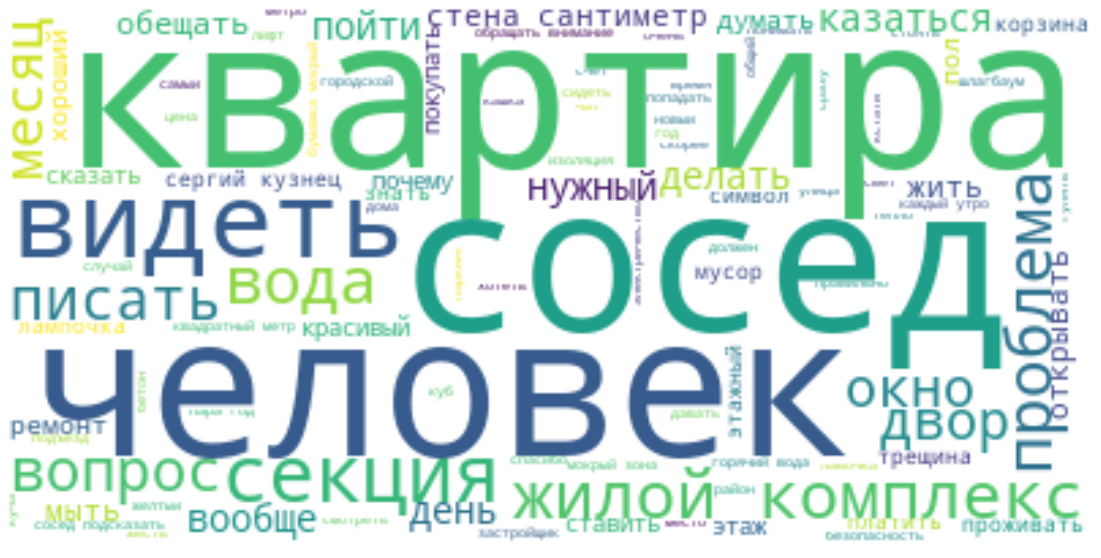

Please, name the cluster: соседский опыт
		 ## CLUSTER 6 TOP-5 MESSAGES ##

Вероятно смена ук

Почему произошло что?)))

Мне тут на днях позвонил дядька, представился михаилом от пи групп, спросил получала ли я письмо от смарта и что я собираюсь с этим делать. Я сказала, что ничего. Он меня спросил а не интересно ли мне почему так произошло, на что я его отлаяла (сама себя испугалась в этот момент 🤣🤣🤣🤣) и сказала что они не имеют права нам диктовать свои условия, что это они для нас а не наоборот и что это мы должны диктовать условия а не наоборот. Дядька положил трубку не прощаясь... вот уже третий день думаю, может стоило послушать его версию событий...все сказка на ночь...или триллер...

Не уводите мысль в сторону - отказываясь от голосования как я вижу предлагается разогнать все УК, никого не выбрать, остаться с безвластием и бардаком и уже в таком прелестном состоянии радостно искать новую УК. 
Это какой-то маразм все же, согласитесь.

На самом деле, со счетами надо разобраться. Я

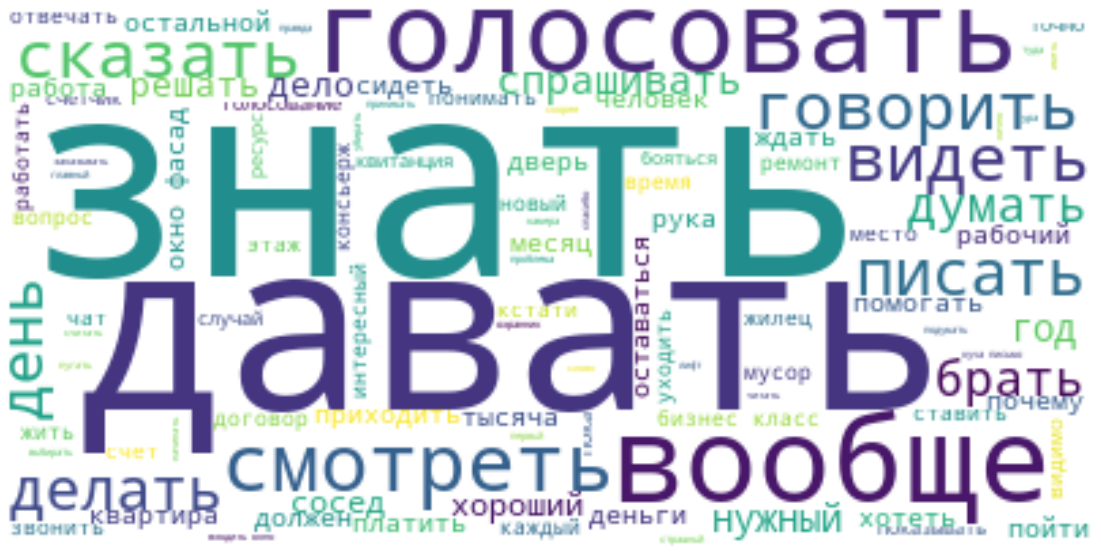

Please, name the cluster: выбор УК


In [53]:
# Get 10 most defining (by tf_idf) words for each cluster
idf_dict = dict(zip(idf_df.word,idf_df.idf))
train = train.reset_index(drop=True)

# most frequent and irrelevant words
words_to_del = ['управлять','компания','дом','мочь','корпус']

clus_words_list = []
clusters = sorted(train.cluster.unique())
for c in clusters:
    idf_sums = {}
    for idx in train[train.cluster==c].index.tolist():
        for w in corpus_clean[idx]:
            if w.lower() in idf_dict and w.lower().split('_')[0] not in words_to_del:
                if w in idf_sums:
                    idf_sums[w] += idf_dict[w.lower()]
                else:
                    idf_sums[w] = idf_dict[w.lower()]
    sums_df = pd.DataFrame({'word':list(idf_sums.keys()),'sum':list(idf_sums.values())}).sort_values('sum', ascending=False)
    clus_words_list.append([i.split('_')[0] for i in sums_df.head(10).word.tolist()])
    
most_defining_ten = pd.DataFrame(dict(zip(clusters,clus_words_list)))
display(most_defining_ten.style.set_caption('10 most defining words for each cluster'))

# get cosine distance to cluster center
train['dist_to_center'] = np.nan
for c in clusters:
    c_mean = gmm_final.means_[c]
    for idx in train[train.cluster==c].index.tolist():
        train.loc[idx,'dist_to_center'] = cos_similarity(train_data[idx],c_mean)
        
# collect all cluster words
all_words_df = pd.DataFrame({'cluster':clusters,'all_words':np.nan})
for c in clusters:
    words = []
    for idx in train[train.cluster==c].index.tolist():
        for w in corpus_clean[idx]:
            w = w.lower().split('_')[0]
            if w not in words_to_del:
                words.append(w)
    all_words_df.loc[all_words_df.cluster==c,'all_words'] = ' '.join(words)

clust_names = []
for clust in clusters:
    print('\t\t ## CLUSTER %i TOP-5 MESSAGES ##'%clust)
    ids = train[train.cluster==clust].sort_values('dist_to_center', ascending=False).head(5).msg_id.tolist()
    for i in ids:
        print('\n%s'%(msg.loc[msg.msg_id==i,'message'].values[0]))
    
    ## print wordcloud
    text = all_words_df[all_words_df.cluster==clust].all_words.values[0]
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)

    plt.figure(figsize=[20,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();
    
    clust_name = str(input('Please, name the cluster: '))
    clust_names.append(clust_name)

In [54]:
# Print suggested names
clust_names_df = pd.DataFrame({'cluster':clusters,'cluster_name':clust_names})
clust_names_df

,cluster,cluster_name
0,1,сравнение УК
1,2,ОСС и голосование
2,3,оплата квитанций
3,4,коммунальные услуги
4,5,соседский опыт
5,6,выбор УК


In [60]:
top_terms = [i.split('_')[0] for i in top_terms if i.split('_')[0] in train.columns]
# Append cluster name to initial data frame
msg = msg.merge(train[['msg_id','cluster']+top_terms].merge(clust_names_df).drop('cluster', axis=1))

## Analytics

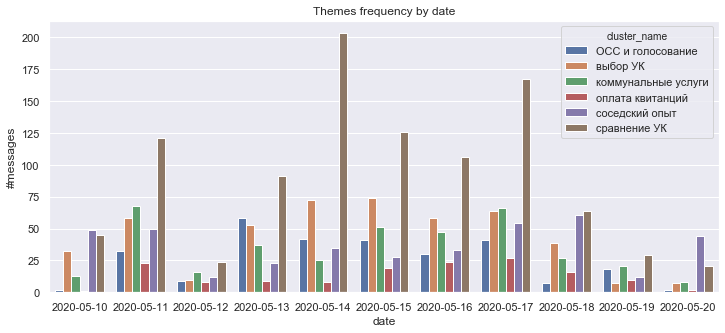

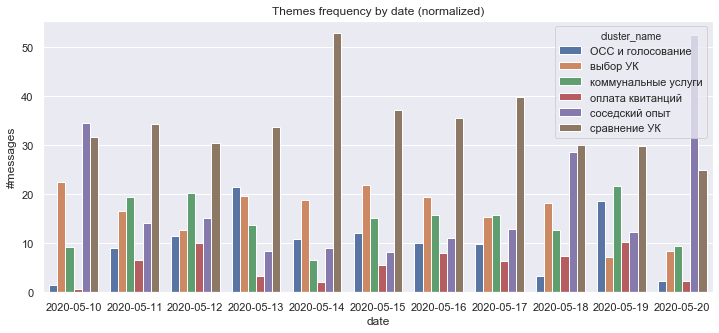

In [62]:
# Plot topics frequency raw and normalized (by # messages a day)
msg['date_only'] = msg.date.dt.date
temp = msg.groupby(['date_only','cluster_name']).msg_id.count().reset_index()
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(data=temp, x='date_only',y='msg_id',hue='cluster_name')
plt.title('Themes frequency by date')
plt.xlabel('date')
plt.ylabel('#messages')
plt.show();

temp['count_norm'] = temp.msg_id / temp.groupby('date_only').msg_id.transform('sum') * 100
sns.barplot(data=temp, x='date_only',y='count_norm',hue='cluster_name')
plt.title('Themes frequency by date (normalized)')
plt.xlabel('date')
plt.ylabel('#messages')
plt.show();

In [69]:
msg.to_pickle('./jksimvol__2020_05_19 23_42/tables/msg_df_clustered.pkl')

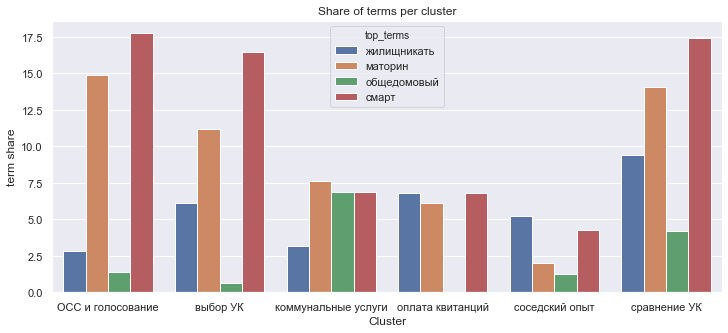

In [77]:
temp = (pd.melt(msg[['cluster_name']+top_terms], id_vars='cluster_name', var_name='top_terms')
        .groupby(['cluster_name','top_terms'])['value'].agg(['sum','count']).reset_index())
temp['term_share'] = temp['sum'] / temp['count'] * 100

sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(data=temp, x='cluster_name',y='term_share',hue='top_terms')
plt.title('Share of terms per cluster')
plt.xlabel('Cluster')
plt.ylabel('term share')
plt.show();

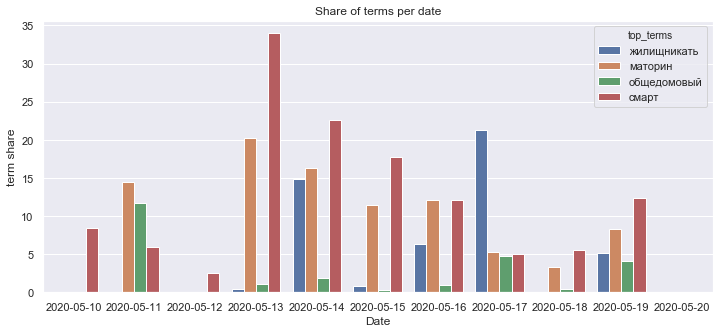

In [79]:
temp = (pd.melt(msg[['date_only']+top_terms], id_vars='date_only', var_name='top_terms')
        .groupby(['date_only','top_terms'])['value'].agg(['sum','count']).reset_index())
temp['term_share'] = temp['sum'] / temp['count'] * 100

sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(data=temp, x='date_only',y='term_share',hue='top_terms')
plt.title('Share of terms per date')
plt.xlabel('Date')
plt.ylabel('term share')
plt.show();

For each cluster we'll print:  
- Top-5 users
- Top-3 most replied-to messages
- Top-3 longest messages
- All links
- All polls

In [196]:
def print_stats(df, cluster, wp, polls):
    '''
    df - dataframe with messages and clusters
    cluster - selected cluster name for stats
    wp - dataframe with msg_id and web links info
    polls - dataframe with msg_id and polls info
    '''
    
    print('\n\t\t ### SHOWING STATS FOR CLUSTER: %s ###'%str(cluster))    
    
    print('\n\t ## Top-5 contributers:\n')
    temp = (df[df.cluster_name==cluster].groupby('user_name').msg_id.count().reset_index()
            .sort_values('msg_id', ascending=False).reset_index(drop=True))
    for i in range(5):
        print('%i:\t%s'%(temp.loc[i,'msg_id'],str(temp.loc[i,'user_name'])))
    
    print('\n\t ## Top-3 most replied-to messages:\n')
    cluster_ids = df.loc[df.cluster_name==cluster,'msg_id'].tolist()
    temp = (df[df.reply_to_msg_id.isin(cluster_ids)].groupby('reply_to_msg_id').msg_id.count().reset_index()
            .sort_values('msg_id', ascending=False).reset_index(drop=True))
    i = 0
    for idx in range(3):
        i+=1
        mid = temp.loc[idx,'reply_to_msg_id']
        rpl = temp.loc[idx,'msg_id']
        user = df.loc[df.msg_id==mid,'user_name'].values[0]
        msg = df.loc[df.msg_id==mid,'message'].values[0]
        dt = df.loc[df.msg_id==mid,'date_only'].values[0]
        print('#%i %s\t(%i replies) - %s:\n%s\n'%(i,str(user),int(rpl),str(dt),str(msg)))
        
    print('\t ## Top-3 longest messages:')
    temp = df.loc[df.cluster_name==cluster,['message','date_only','user_name']].copy()
    temp['msg_length'] = temp['message'].astype(str).str.len()
    i=0
    temp = temp.sort_values('msg_length', ascending=False).reset_index(drop=True).head(3)
    for idx in temp.index:
        i+=1
        user = str(temp.loc[idx,'user_name'])
        dt = str(temp.loc[idx,'date_only'])
        m = str(temp.loc[idx,'message'])
        print('\n#%i %s\t%s\n%s\n'%(i,user,dt,m))
        
    print('\t ## Web-Links:')
    i=0
    for idx in wp[wp.msg_id.isin(df.loc[df.cluster_name==cluster,'msg_id'].tolist())].index:
        i+=1
        print('\n#%i (%s)'%(i,wp.loc[idx,'type']))
        print('URL: %s'%(wp.loc[idx,'url']))
        print('TITLE: %s'%(wp.loc[idx,'title']))
    
    print('\n\t ## Polls:')
    i=0
    for idx in polls[polls.msg_id.isin(df.loc[df.cluster_name==cluster,'msg_id'].tolist())].index:
        user = df.loc[df.msg_id==polls.loc[idx,'msg_id'],'user_name'].values[0]
        quest = polls.loc[idx,'question']
        print('\n#%i (%s):\t%s'%(i,str(user),str(quest)))
        print('Variants:\t%s'%str(polls.loc[idx,'variants']))
        print('Winning:\t%s (%.2f pct. of %i voted so far)'%
              (str(polls.loc[idx,'highest']),polls.loc[idx,'share']*100,polls.loc[idx,'total_voted']))
        print('Closing date:\t%s'%str(polls.loc[idx,'close_date']))

In [197]:
for cluster in msg.cluster_name.unique():
    print_stats(msg,cluster,wp,polls)


		 ### SHOWING STATS FOR CLUSTER: сравнение УК ###

	 ## Top-5 contributers:

101:	Fainka_(343553091)
78:	Роман_Романофф_(663496404)
57:	Anna_Sveshnikova_(340148348)
50:	Николай_Владимирович_(510863780)
47:	Lolli_(817793736)

	 ## Top-3 most replied-to messages:

#1 Александра_Ян_(576951018)	(8 replies) - 2020-05-11:
Давайте возьмём этого адвоката на весь комплекс Свободы. Ну или отдельно домами.

#2 Кирилл_(113868797)	(7 replies) - 2020-05-14:
Доброго вечера Уважаемые жители. Благодарю Вас за добрые слова, одновременно прошу прощения за те проблемы которые были и у сравнительно небольшого количества собственников еще остаются в Ваших квартирах. Комплекс огромен и довести до ума его сразу сложно, особенно без должного подхвата эксплуатацией. В СМАРТе потенциала в разы больше чем в его предшественнике, а Ваша воля и энергия даст необходимую мотивацию и большое и сложное хозяйство будет отлажено окончательно. Хочу так же поблагодарить Вас за активность. Сообщить что проблема с шумами ве


#3 Александра_Ян_(576951018)	(3 replies) - 2020-05-13:
Не надо участвовать в осс Смарта, пускай кворум не наберется.

	 ## Top-3 longest messages:

#1 Полина_(783488334)	2020-05-13
Мне тут на днях позвонил дядька, представился михаилом от пи групп, спросил получала ли я письмо от смарта и что я собираюсь с этим делать. Я сказала, что ничего. Он меня спросил а не интересно ли мне почему так произошло, на что я его отлаяла (сама себя испугалась в этот момент 🤣🤣🤣🤣) и сказала что они не имеют права нам диктовать свои условия, что это они для нас а не наоборот и что это мы должны диктовать условия а не наоборот. Дядька положил трубку не прощаясь... вот уже третий день думаю, может стоило послушать его версию событий...все сказка на ночь...или триллер...


#2 Полина_(783488334)	2020-05-17
Наш дом года 3 назад пережил капремонт. Все сделали чисто, аккуратно, люльки за окнами нам не машали. Гл.инженер и начальник ремонта лично ходили по каждой квартире и спрашивали проблемы и т.д., к концу ре


	 ## Web-Links:

#1 (article)
URL: https://corconsult.ru/blog/mm-np
TITLE: Почему машино-место ставят на кадастровый учет как нежилое помещение

#2 (article)
URL: http://mingkh.ru/rating/moskva/moskva/
TITLE: Рейтинг управляющих компаний ЖКХ и ТСЖ в Москве

#3 (article)
URL: https://m.market.yandex.ru/product--setevaia-kamera-xiaomi-xiaobai-smart-ip-camera-public-version-720p/639932130?hid=6202209&show-uid=15851566431541203149716004&from=search&glfilter=7893318%3A7701962&local-offers-first=0&onstock=1&text=xiaomi%20%D0%BA%D0%B0%D0%BC%D0%B5%D1%80%D0%B0
TITLE: Сетевая камера Xiaomi Xiaobai Smart IP Camera Public Version 720p — купить по выгодной цене на Яндекс.Маркете

#4 (document)
URL: https://docs.google.com/spreadsheets/d/1VbjROy-gbeOdepDPko2ipy4oevuj3YbJvQv-wLkdI2M/edit
TITLE: Конструктор тарифа

#5 (article)
URL: http://franchise.ukliga.ru/
TITLE: Франшиза "Лиги ЖКХ"

#6 (telegram_channel)
URL: https://t.me/simvol_smartvostok
TITLE: ЖК СИМВОЛ. СМАРТ ВОСТОК

#7 (article)
URL: https